# 3/11/20
____
Напишу свою рад.попр. функцию

In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob

%matplotlib inline

sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.7)
plt.style.use('seaborn-whitegrid')

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

In [2]:
import scipy.integrate as integrate
import numpy as np

class RadCor:
    alpha = 7.297e-3
    me = 0.511 #MeV
    
    def __init__(self):
        return
    def l(self, E, dE):
        return np.log(E/dE)
    def L(self, s):
        me = self.me
        return np.log(s/(me**2))
    def beta(self, s):
        a = self.alpha
        p = np.pi
        return (2*a/p)*(self.L(s) - 1)
    
    def soft_terms_rad(self, E, dE):
        a = self.alpha
        p = np.pi
        s = 4*(E**2)
        l = self.l(E, dE)
        L = self.L(s)
        
        s1 = -2*l*(L-1) + 3*L/2 + (p**2)/3 - 2
        s2 = (1/2)*((-2*l*(L-1))**2)
        s3 = (3*L/2 + (p**2)/3 - 2)*(-2*l*(L-1))
        s4 = (L**2)*( -l/3 + 11/8 - (p**2)/3 )
        s5 = L*(2*(l**2)/3 + 10*l/9 - 203/48 + 11*(p**2)/12 + 3*1.202)
        s6 = -(4/9)*(l**3) - (10/9)*(l**2) - (2/9)*(28/3 - p**2)*l
        
        result = 1 + (a/p)*s1 + ((a/p)**2)*(s2 + s3 + s4 + s5 + s6)
        return result
    def soft_terms_cs(self, E, cs, dE):
        return self.soft_terms_rad(E, dE)/cs
        
    def F(self, x, s):
        a = self.alpha
        b = self.beta(s)
        p = np.pi
        L = self.L(s)
        m = self.me
        E = np.sqrt(s)/4
        
        s1 = (a/p)*( (p**2)/3 - 1/2 ) + 3*b/4
        s2 = ( (b**2)/24)*(L/3 + 2*(p**2) - 37/4 )
        s3 = -b*(1-x/2)
        s4 = 4*(2-x)*np.log(1/x)
        s5 = (1/x)*(1+3*((1-x)**2))*np.log(1/(1-x))
        s6 = - 6 + x
        
        s7 = 0 if x<(2*m/E) else (1/(6*x))*((x - 2*m/E)**b)*\
            ((np.log(s*(x**2)/(m**2)) - 5/3)**2)*\
            (2 - 2*x + x**2 + (b/3)*(np.log(s*(x**2)/(m**2)) - 5/3))
        s8 = 0 if x<(2*m/E) else ((L**2)/2)*((2/3)*((1-(1-x)**3)/(1-x)) -\
            (2-x)*np.log(1/(1-x)) + x/2 )
        
        
        result = b*(x**(b-1))*( 1 + s1 + s2 ) + s3 + \
        (1/8)*(b**2)*(s4 + s5 + s6) + \
        ((a/p)**2)*(s7 + s8)
        return result
    
    def F_Integral(self, e, cs, e_beam, Xmax=1):
        s = 4*(e_beam**2)
        s_cs = 4*(e**2)
        if not( np.all(np.diff(s_cs) > 0) ):
            print('Problem')
        return integrate.quad( lambda x: self.F(x, s)*np.interp(s*(1-x), s_cs, cs), 0., Xmax, points=[0, 1], 
                              limit=1000, epsrel=0.001)#epsabs=1e-3)
    def F_Radcor(self, e, cs, e_beam, Xmax=1):
        integral = self.F_Integral( e, cs, e_beam, Xmax)
        return ( integral[0]/np.interp(e_beam, e, cs), integral[1]/np.interp(e_beam, e, cs) )

In [3]:
with open('code/cs_klks_cmd2') as f:
    txt = f.readlines()
e = np.array( list(map(lambda x: float(x.split(' ')[1])/2, txt) ) )
cs = np.array( list(map(lambda x: float(x.split(' ')[2]), txt) ) )

In [4]:
r = RadCor()

In [5]:
np.interp(550, e, cs)

3.53007

In [6]:
r.F_Radcor(e, cs, 750, 1)#50/550)

(3.969057739236585, 5.321976165203583e-08)

In [7]:
x = np.linspace(500, 520, 50)
rcors = [ r.F_Radcor(e, cs, i, 1)[0] for i in x ]

In [8]:
r.F_Radcor(e, cs, 1059.947/2, 0.8003)

(2.070562197108857, 0.0002956066930192251)

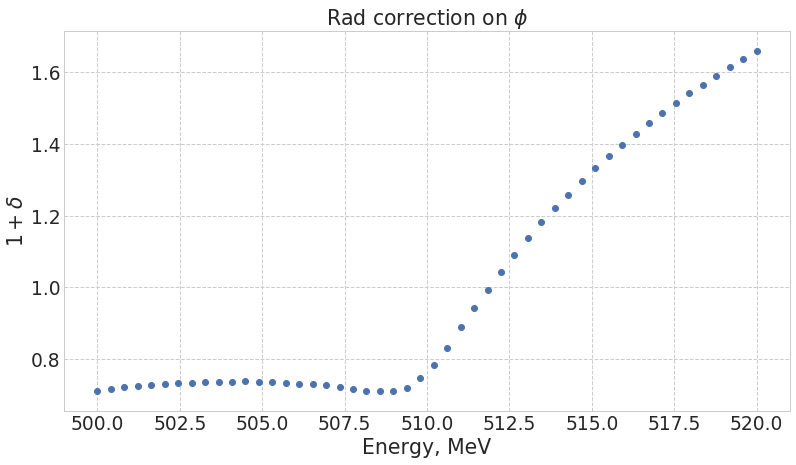

In [12]:
plt.scatter(x, rcors)
my_style('Rad correction on $\phi$', 'Energy, MeV', '$1+\delta$', '--')
# plt.savefig('outputs/images/10_rad_phi.png')

Посмотреть на файл с MC

In [21]:
soft_photons = 25 #MeV

tree = uproot.open('/store17/petrov/data/kskl_sim/tr_ph_run004880.root')['tr_ph'] #old mc_v7
nevents = tree.pandas.df(branches=['simtype', 'simmom', 'simorig']).query('simtype==22&simorig==0')[['simmom']]

ebeam = tree.array('emeas').mean()
print('Энергия пучка:', ebeam, 'МэВ')

num_norads = len( tree.pandas.df(branches=['simtype', 'simmom', 'simorig']).query('simorig==0').\
      groupby('entry').agg({'simmom':'count'}).query('simmom==2') )


sum_energy_per_event = nevents.groupby('entry').agg({'simmom': 'sum'})

num_soft = num_norads + len( sum_energy_per_event.query('simmom<@soft_photons') )
num_full = len(sum_energy_per_event) + num_norads

Энергия пучка: 550.0 МэВ


In [22]:
def plot_radcors(soft_photons):
    rc = r.F_Radcor(e, cs, ebeam, soft_photons/ebeam)
    return [ rc[0], rc[1] ]
def soft_events(soft_photons, reject_num=0):
    num_soft = num_norads + len( sum_energy_per_event.query('simmom<@soft_photons') ) - reject_num
    if num_soft<0:
        return [ 0, 0 ]
    return [ num_soft, np.sqrt(num_soft) ]

In [23]:
x = np.linspace( 5, min(ebeam, 2*(ebeam-497.6) ) , 100)
y = np.array( [soft_events(i) for i in x ] )
y, yerr = y.T/np.max(y)

yr = np.array( [plot_radcors(i) for i in x ] )
yr, yrerr = yr.T/np.max(yr)

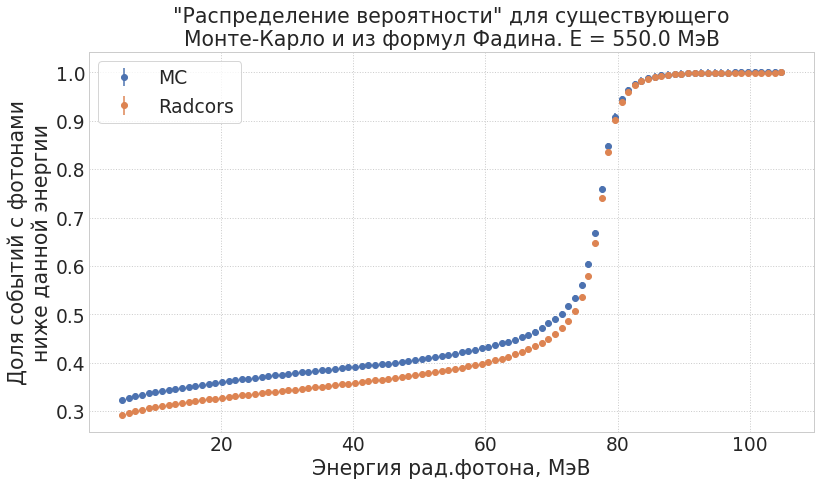

In [28]:
plt.errorbar(x, y, yerr=yerr, fmt='o', label='MC')
plt.errorbar(x, yr, yerr=yrerr, fmt='o', label='Radcors')
plt.legend(frameon=True)
my_style(f'"Распределение вероятности" для существующего\nМонте-Карло и из формул Фадина. E = {ebeam} МэВ', 
         'Энергия рад.фотона, МэВ', 'Доля событий с фотонами\nниже данной энергии')
# plt.savefig('outputs/images/10_distr_mc.png')

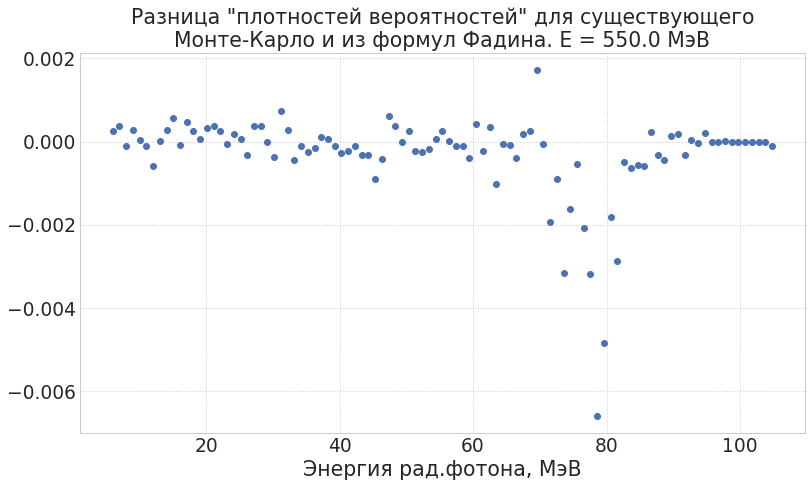

In [31]:
plt.errorbar(x[1:], (y[1:] - y[:-1]) - (yr[1:] - yr[:-1]), fmt='o', label='MC' )
my_style(f'Разница "плотностей вероятностей" для существующего\nМонте-Карло и из формул Фадина. E = {ebeam} МэВ', 
         'Энергия рад.фотона, МэВ', '')
#              yerr= np.sqrt( y[1:]**2 + y[:-1]**2 + yr[1:]**2 + yr[:-1]**2) )
# plt.errorbar(x[1:], )
# plt.savefig('outputs/images/10_dense_mc.png')

<ErrorbarContainer object of 3 artists>

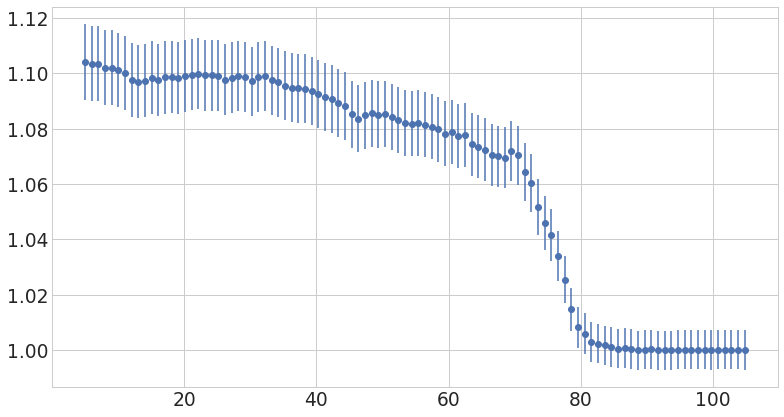

In [26]:
plt.errorbar(x, y/yr, yerr=(y/yr)*np.sqrt( (yerr/y)**2 + (yrerr/yr)**2 ), fmt='o', label='residual')
# plt.legend(frameon=True)

In [36]:
sp = 50

def plot_radcors_by_energy(ebeam):
    rc = r.F_Radcor(e, cs, ebeam, sp/ebeam)
    rc_max = r.F_Radcor(e, cs, ebeam, 1)
    return [ rc[0]/rc_max[0], rc[1]/rc_max[0] ]

def soft_events_by_energy():
    trees = uproot.pandas.iterate('/store17/petrov/data/kskl_sim/tr_ph_run00*.root', treepath='tr_ph', 
                                  branches=['simtype', 'simmom', 'simorig', 'emeas'], reportpath=True)
    ebeams = []
    rcs = []
    rcserrs = []
    for p, df in trees:
#         print(len(df))
        nevents = df.query('simtype==22&simorig==0')[['simmom']]
        ebeam = df['emeas'].mean()
        ebeams.append(ebeam)
        
        num_norads = len( df.query('simorig==0').\
          groupby('entry').agg({'simmom':'count'}).query('simmom==2') )
        
        sum_energy_per_event = nevents.groupby('entry').agg({'simmom': 'sum'})

        num_soft = num_norads + len( sum_energy_per_event.query('simmom<@sp') )
        num_full = len(sum_energy_per_event) + num_norads
#         print(p, ebeam, num_soft)
        rcs.append(num_soft/num_full)
        rcserrs.append( (num_soft/num_full)*(1/np.sqrt(num_soft) + 1/np.sqrt(num_full)) )
    return np.array([ebeams, rcs, rcserrs])

In [37]:
xes, rces, rcserrs = soft_events_by_energy()

In [38]:
xe = np.linspace(550, 1020, 50)
rc, rcerr = np.array( [plot_radcors_by_energy(i) for i in xe] ).T

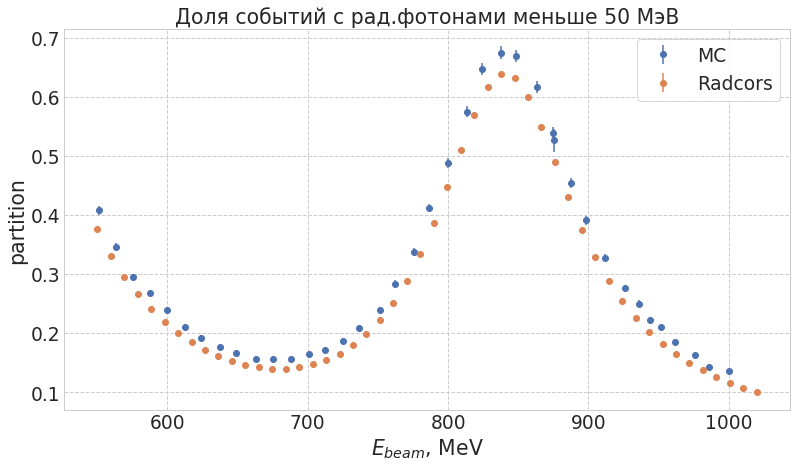

In [40]:
plt.errorbar(xes, rces, yerr=rcserrs, fmt='o', label='MC')
plt.errorbar(xe, rc, yerr=rcerr, fmt='o', label='Radcors')
plt.legend(frameon=True)
my_style(f'Доля событий с рад.фотонами меньше {sp} МэВ', '$E_{beam}$, MeV', 'partition', '--')
# plt.savefig('outputs/images/10_part_mc.png')

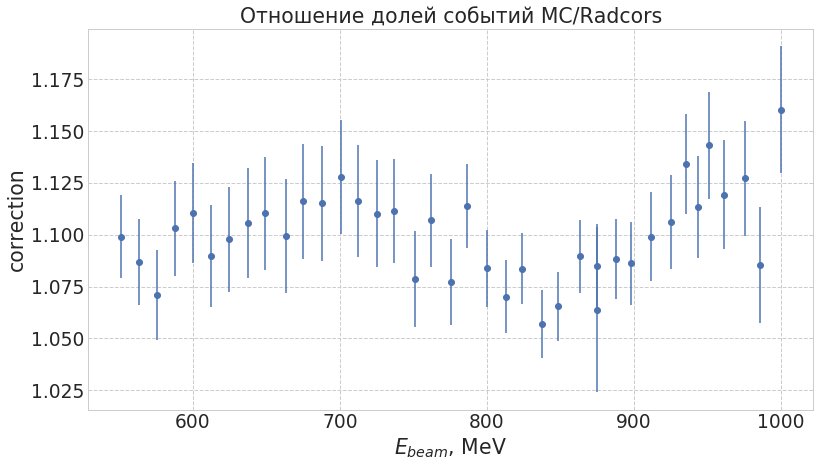

In [41]:
plt.errorbar(xes, rces/np.interp(xes,xe,rc), yerr=rcserrs/np.interp(xes,xe,rc), fmt='o', label='residual')
my_style('Отношение долей событий MC/Radcors', '$E_{beam}$, MeV', 'correction', '--')
# plt.savefig('outputs/images/10_corr_mc.png')

Пусть $\sigma_{r}$ - правильное (right) сечение с абсолютно точным моделированием

$$\sigma_{r} = \frac{n_0}{\varepsilon (1+\delta)} = \frac{n_0}{\frac{N_0}{N_0^t + N_\gamma^t} (1+\delta) } = \frac{n_0}{N_0/N_0^t} \frac{(1+N_\gamma^t/N_0^t)}{(1+\delta)}$$

А если MC не такое точное, тогда я получу сечение $\sigma_{w}$ (wrong)

$$\sigma_{w} = \frac{n_0}{\varepsilon' (1+\delta)} = \frac{n_0}{\frac{{N'}_0}{ {N'}_0^t + {N'}_\gamma^t} (1+\delta) } = \frac{n_0}{{N'}_0/{N'}_0^t} \frac{(1+{N'}_\gamma^t/{N'}_0^t)}{(1+\delta)}$$

Из предыдущих формул получается, что

$$\sigma_{r} = \sigma_{w} \frac{{N'}_0/{N'}_0^t}{N_0/N_0^t} \frac{1+N_\gamma^t/N_0^t}{1+{N'}_\gamma^t/{N'}_0^t} $$

Где первый множитель - это поправка на эффективность реконструкции "упругого" процесса, а второй - поправка на события с рад. фотоном

Пройдусь минуитом, попробую отсечь нужное количество событий

In [20]:
from iminuit import Minuit

def reject_finder(reject):
    x = np.linspace( 5, min(ebeam, 2*(ebeam-497.6) ) , 50)
    y = np.array( [soft_events(i, reject)[0] for i in x ] )
    yr = np.array( [plot_radcors(i)[0] for i in x ] )
    y = y/np.max(y)
    yr = yr/np.max(yr)
    return np.sum((y-yr)**2)

m = Minuit(reject_finder, reject=0.7e3, error_reject=0.1e3, limit_reject=(0, 1e4), errordef = 1)

m.migrad()  # run optimiser

------------------------------------------------------------------
| FCN = 4.114E-05               |      Ncalls=18 (18 total)      |
| EDM = 4.71E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------------------------------------------------------------------------------------
| 0 | reject |  0.03E4   |  0.77E4   |            |            |    0    |  10000  |       |
--------------------------------------------------------------------------------------------

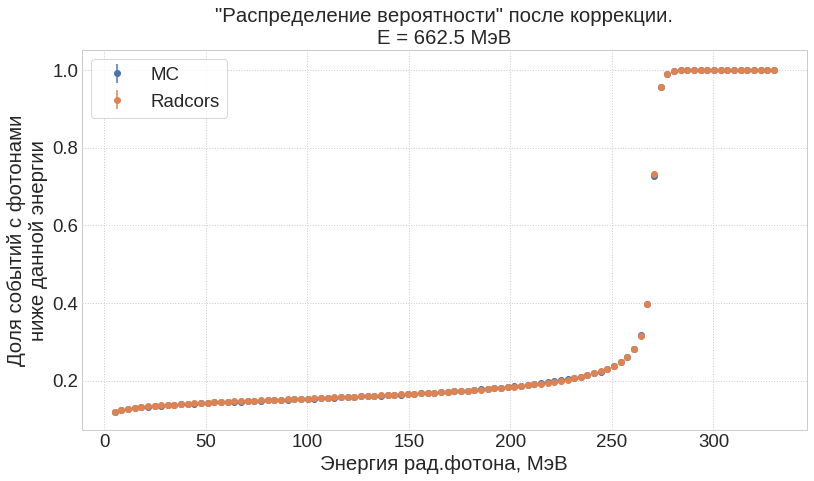

In [232]:
x = np.linspace( 5, min(ebeam, 2*(ebeam-497.6) ) , 100)
y = np.array( [soft_events(i, m.values[0]) for i in x ] )
y, yerr = y.T/np.max(y)

yr = np.array( [plot_radcors(i) for i in x ] )
yr, yrerr = yr.T/np.max(yr)

plt.errorbar(x, y, yerr=yerr, fmt='o', label='MC')
plt.errorbar(x, yr, yerr=yrerr, fmt='o', label='Radcors')
plt.legend(frameon=True)
my_style(f'"Распределение вероятности" после коррекции.\nE = {ebeam} МэВ', 
         'Энергия рад.фотона, МэВ', 'Доля событий с фотонами\nниже данной энергии')

<ErrorbarContainer object of 3 artists>

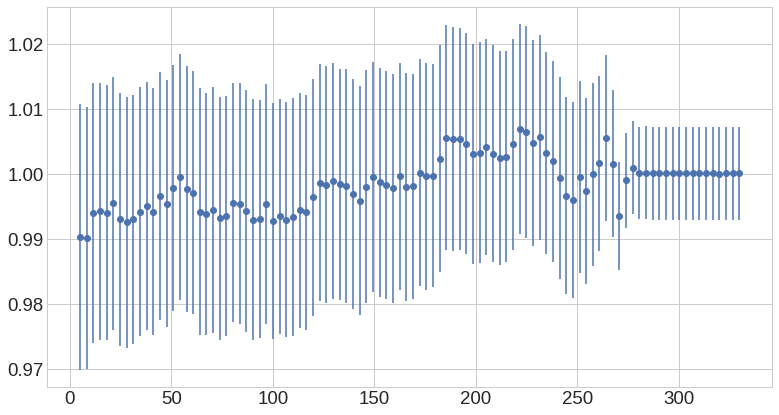

In [213]:
plt.errorbar(x, y/yr, yerr=(y/yr)*np.sqrt( (yerr/y)**2 + (yrerr/yr)**2 ), fmt='o', label='residual')
# plt.legend(frameon=True)